# Elife Paper 
## Figure 3: Success of the model
- A. Joing spectrogram of 4 syllables
- B. Trajectory plots for 4 syllables
- C. Detailed trajectory plot for 1 syllable
- D. Creating artifical landscapes with different number of distractors

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
from functions import *
import queue
from scipy.integrate import solve_ivp
from env_lite import Environment
from model import NN

### A. Song Spectrogram - 4 syllables joint plot

In [2]:
## Syrinx Spectrogram
# np.random.seed(100)
# Parameters
gamma = 12000 

duration = 0.050 #s
dt = 1/44100 #s  #* 0.1 #1.e-4

Amp = 10

# Trachea parameters
r=-0.9
v=350*100
L=1.9
tau_0=2*L/v # Propagation time along trachea
tau_n=int(tau_0/dt)
# ks = np.linspace(0.16,0.52, 10)
# ps = np.linspace(1852,2084, 10)

# Track position and velocity 
nt = int(duration/dt)
X = np.zeros(nt)          # Labial position
Y = np.zeros(nt)          # Velocity

def sigmoid(x):
      return 1 / (1 + np.exp(-x))

def syrinxODE(t, y):
    ''' ODEs used in Amador paper'''
    
    y0, y1 = y
    dydt = [y1,
         -Pressure(t)*(gamma**2) - Tension(t)*(gamma**2)*y0 - (gamma**2)*(y0**3) - gamma*(y0**2)*y1 + (gamma**2)*(y0**2) - gamma*y0*y1
           ]
    return dydt

# RC4
# syllable 1
syllable_array = [1,2,3,4]
P_t_list = []  # <— add before the syllable loop




for syllable in syllable_array:
    if syllable == 1:
        def Tension(t):
            """ Generalised exponential waveform """
            return   .3 - .2*np.exp(-200*t) -.00001 * np.exp(200*t) 

        
        def Pressure(t):
            """ Constant """
            return 0.04*np.sin((duration/2 + t)*np.pi*10) + 0.05
    # RC5 - test
    elif syllable == 2:
        # syllable 2
        def Tension(t):
            """ Generalised exponential waveform """
            Tc = 1#2/3
            return   .3 - .2*np.exp(-Tc*3*100*t) -.00001 * np.exp(Tc*3*100*t) 

        def Pressure(t):
            """ Constant """
            tp = 0.2
            return tp*np.sin((duration/2 + t)*np.pi*10) + 0.05
    elif syllable == 3:
        # syllable 3
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            scale = 1
            if isinstance(t, float):
                if t <= duration*scale/2: 
                    return 5*np.sin(t*np.pi*40/scale) + 0.6 # old amp 0.1
                elif t <= duration*scale: 
                    return 10*np.sin((t-duration*scale/2)*np.pi*15/scale) + 0.6 # old amp 0.2
                else: 
                    return 0.0 + 0*t
            elif isinstance(t, np.ndarray):
                Tension1 = 5*np.sin(t*np.pi*40/scale) + 0.6 # old amp 0.1
                Tension2 = 10*np.sin(t*np.pi*15/scale) + 0.6 # old amp 0.2
                Tension3 = 0.0 + 0*t
                return np.concatenate((Tension1[:int(np.ceil(t.size*scale/2))], Tension2[:int(t.size*scale-t.size*scale/2)], Tension3[:int(t.size-t.size*scale)]))        
        
        def Pressure(t):
            """ Pressure = 0.02 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 2 # old amp 0.16
    elif syllable == 4:
        # syllable 4
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            scale = 0.4
            if isinstance(t, float):
                if t <= duration*scale: 
                    return 0.8*np.sin(t*np.pi*20/scale) + 0.6 # old amp 0.1
                else: 
                    return t*0 + 0.6 # old amp 0.2
            elif isinstance(t, np.ndarray):
                Tension1 = 0.8*np.sin(t*np.pi*20/scale) + 0.6 # old amp 0.1
                Tension2 = t* 0 + 0.6 # old amp 0.2
                return np.concatenate((Tension1[:int(np.ceil(t.size*scale))], Tension2[:int(t.size-t.size*scale)]))
            
        def Pressure(t):
            """ Pressure = 0.02 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.01
            
    elif syllable == 5:
        # syllable 5
        def Tension(t):
            """ Tension = 0.2 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.2
            
        def Pressure(t):
            """ Pressure = 0.1 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.1
    elif syllable == 6:
        # syllable 6
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            if isinstance(t, float):
                if t <= duration/2: return 0.1*np.sin(t*np.pi*40) + 0.6
                else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.6
            elif isinstance(t, np.ndarray):
                Tension1 = 0.1*np.sin(t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(t*np.pi*15) + 0.6
                return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
            
        def Pressure(t):
            """ Pressure = 0.01*np.sin(sin_t*np.pi*2*100) + 0.02 """
            return 0.01*np.sin(t*np.pi*2*100) + 0.02
        

    solution = solve_ivp(syrinxODE, [0, duration], [1, 1], method = "RK45", t_eval = np.linspace(0,duration,nt), rtol = 1e-8, atol = 1e-8)
    # Extract labial position (X) and velocity (Y)
    X = solution['y'][0]
    Y = solution['y'][1]
    # Transform into song
    time_x = np.linspace(0, duration, nt)
    song = Amp * Pressure(time_x) * Y
    ## Trachea from Darshan, et. al. https://doi.org/10.1038/ncomms15415

    # Input to trachea = output of syrinx
    y0 = song.T

    # To generate pressure output from trachea
    P_i=np.zeros((len(y0)))

    # See Fig 1 in Amador paper. Round-about way to implement that.
    Buffer = queue.Queue()
    for i in np.arange(tau_n):
        Buffer.put(np.random.random())

    for i in np.arange(len(y0)):
        P_i[i] = y0[i] - r*Buffer.get();      
        # update_buffer
        Buffer.put(P_i[i])

    # P_tr from P_in (ref Amador paper)
    BufferB=np.zeros((tau_n))
    P_tmp= np.concatenate((BufferB, P_i))
    P_t=(1-r)*P_tmp[:-tau_n]
    # ... inside your syllable loop, after computing P_t ...
    P_t_list.append(P_t.copy())
    time_x = np.linspace(0, duration, nt)




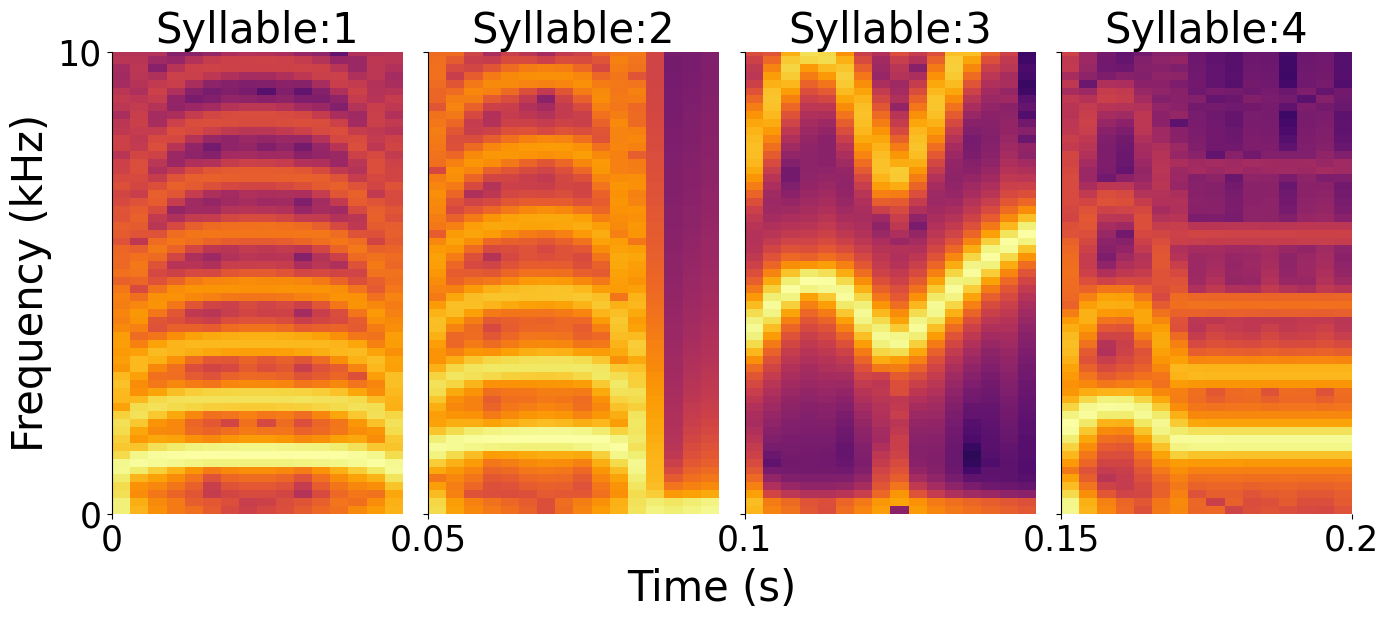

In [3]:
# Parameters for panel width and labeling step
seg = 0.05  # each subplot spans 0.05 s

figure, axes = plt.subplots(
    1, len(syllable_array),
    figsize=(4*len(syllable_array), 6),
    sharey=True, sharex=False,                 # sharey, but NOT sharex
    gridspec_kw={'wspace': 0.09}               # tight horizontal spacing
)

# Ensure axes is always a list, even for single subplot
if len(syllable_array) == 1:
    axes = [axes]

# Store spectrograms for each syllable
spectrograms = []

def fmt_tick(x):
    s = f"{x:.2f}".rstrip('0').rstrip('.')
    return s

for i, syllable in enumerate(syllable_array):
    # time window this panel represents in the global timeline
    x0 = i * seg
    x1 = (i + 1) * seg

    # pick the right pressure trace for this syllable
    P_src = P_t_list[i]  # assumes you appended in the simulation loop

    # Generate spectrogram positioned in the global time coordinates
    spectrumP, freqsP, t_bins, im = axes[i].specgram(
        P_src, Fs=1/dt, NFFT=256, noverlap=128,
        xextent=[x0, x1], cmap='inferno'
    )

    # Store spectrogram data
    spectrograms.append({
        "syllable": syllable,
        "spectrum": spectrumP,
        "freqs": freqsP,
        "time": t_bins,
        "image": im,
        "xrange": (x0, x1),
        "P_t": P_src
    })

    # Configure each subplot

    axes[i].set_title(f'Syllable:{syllable}', fontsize=30)
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].spines['bottom'].set_visible(False)
    axes[i].set_ylim(0, 10000)
    axes[i].set_xlim(x0, x1)
    # axes[i].set_yticklabels

    # ✅ Global-style ticks:
    # Only left edge ticks, except last panel shows both left+right
    if i < len(syllable_array) - 1:
        axes[i].set_xticks([x0])
        axes[i].set_xticklabels([fmt_tick(x0)])
    else:
        axes[i].set_xticks([x0, x1])
        axes[i].set_xticklabels([fmt_tick(x0), fmt_tick(x1)])

    # Y ticks
    axes[i].set_yticks([0, 10000])
    if i == 0:
        axes[i].set_yticklabels([0, 10])
    # else:
        # axes[i].set_yticklabels([])  # cleaner, contiguous look

    axes[i].tick_params(labelsize=25)
# # After the for loop ends (all syllables plotted) ...

# # Add one shared colorbar for the spectrograms
# cbar = figure.colorbar(
#     spectrograms[0]["image"],    # use the first specgram’s image handle
#     ax=axes,
#     orientation='vertical',
#     fraction=0.02,               # size of colorbar
#     pad=0.04                     # distance from plots
# )

# cbar.set_label("Power (dB)", fontsize=20)
# cbar.ax.tick_params(labelsize=15)

# Set labels only on the leftmost subplot
axes[0].set_ylabel('Frequency (kHz)', fontsize=30)
figure.supxlabel('Time (s)', fontsize=30, y = -0.05)
# plt.tight_layout()
# figure.subplots_adjust(wspace=0.1)  # extra-tight spacing between panels
plt.show()


### B. Trajectory plots for all 4 syllables
Put value of `model_version` as model_2.

Keep `load` to False and `save` to True if this is the first time using the notebook. Else `load` to True.


In [4]:
model_2 = 'model_syrinx_4_41'
model_3 = 'model_syrinx_1_37'

In [5]:
# load parameters from json file
params_path = "params_3.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

In [6]:
# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 37
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING) 
print(f'Random seed is {RANDOM_SEED}')

1
Random seed is 37


In [7]:
# Config
# 1 to load model
# 1 to save model
load = 1
save = 0
model_version = model_2  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")


Model 'model_syrinx_4_41' loaded successfully!


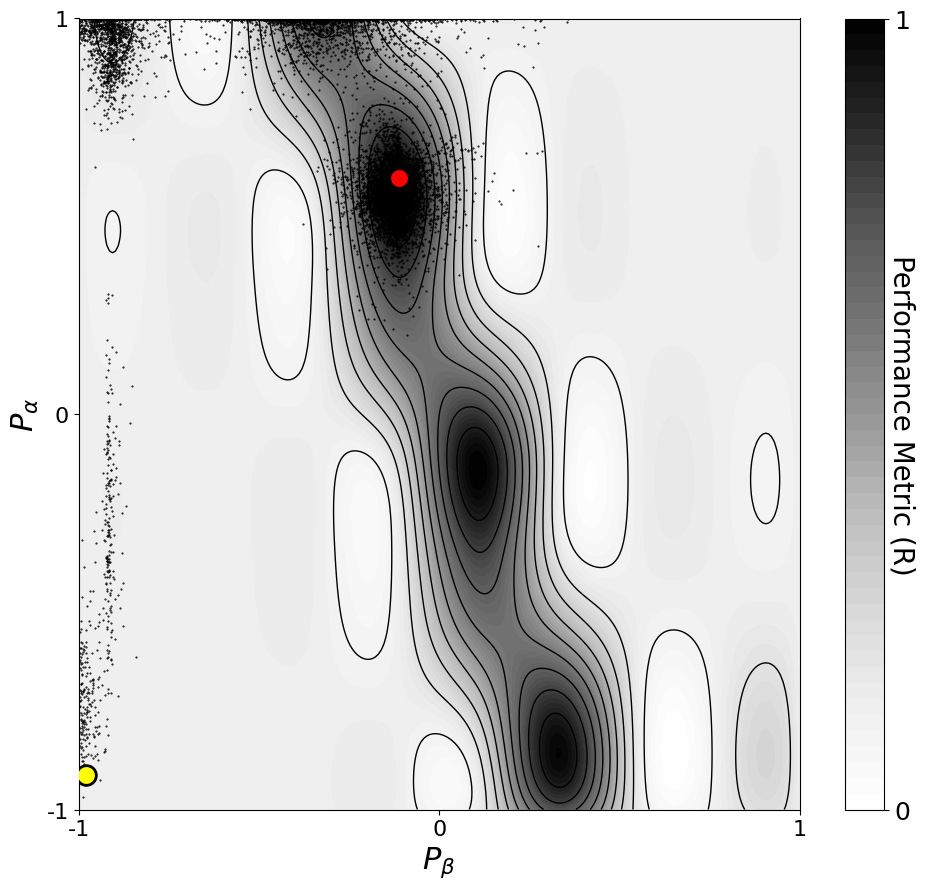

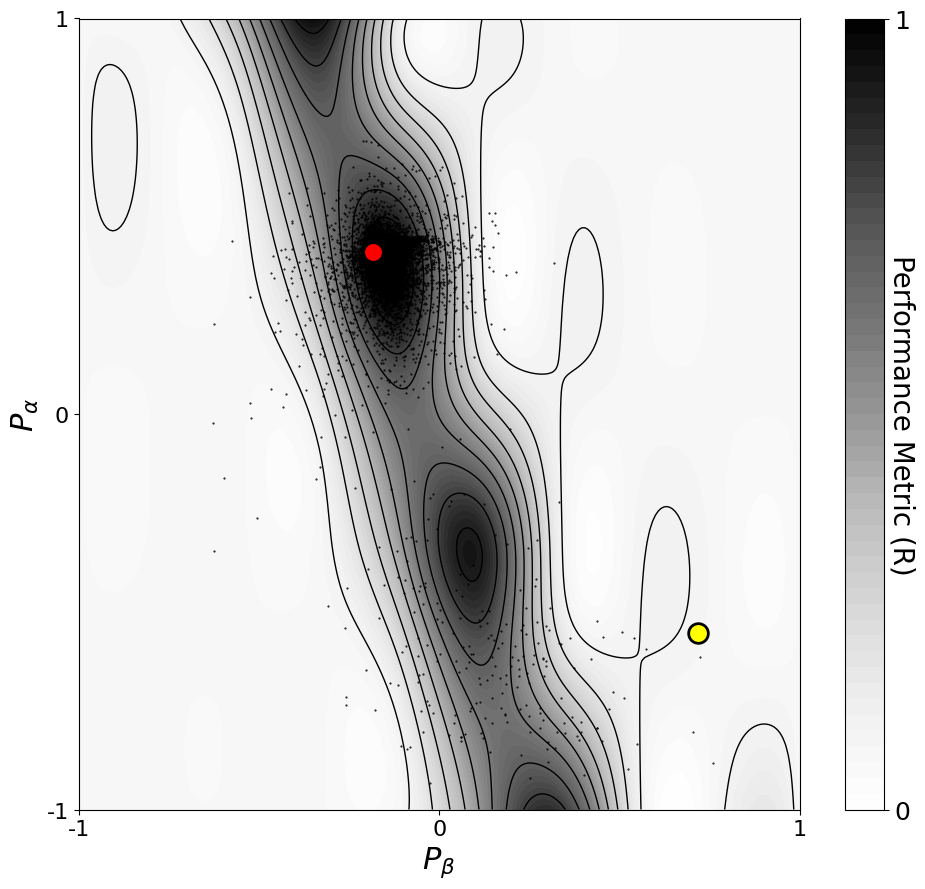

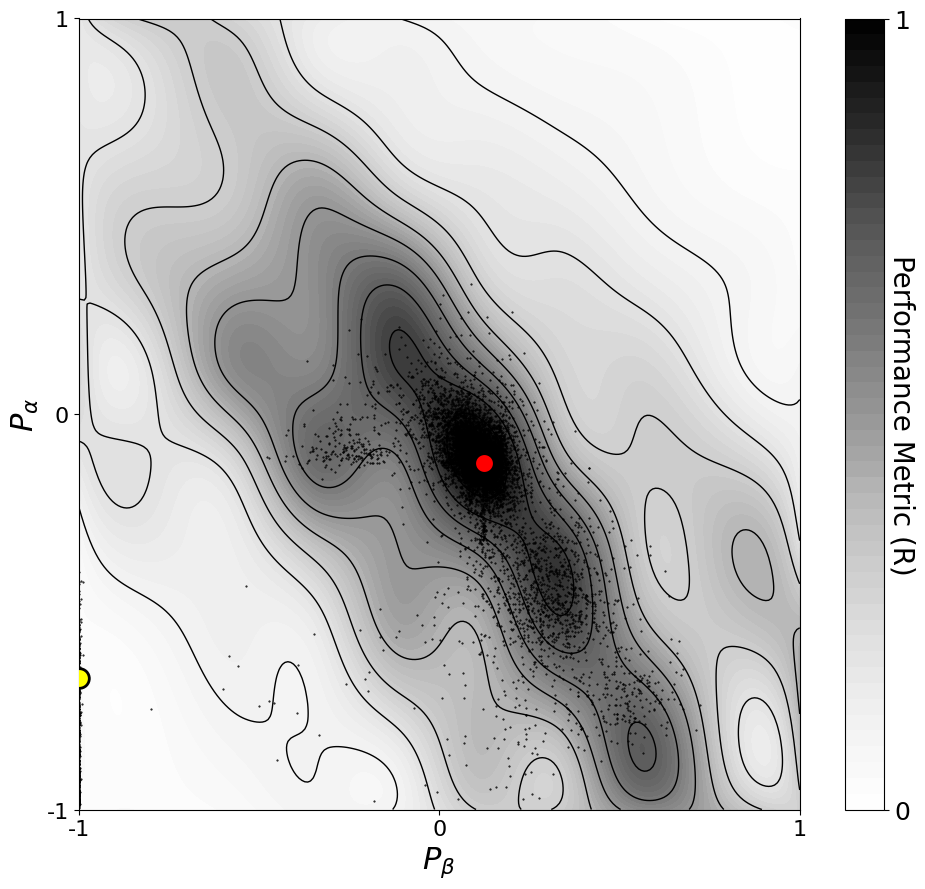

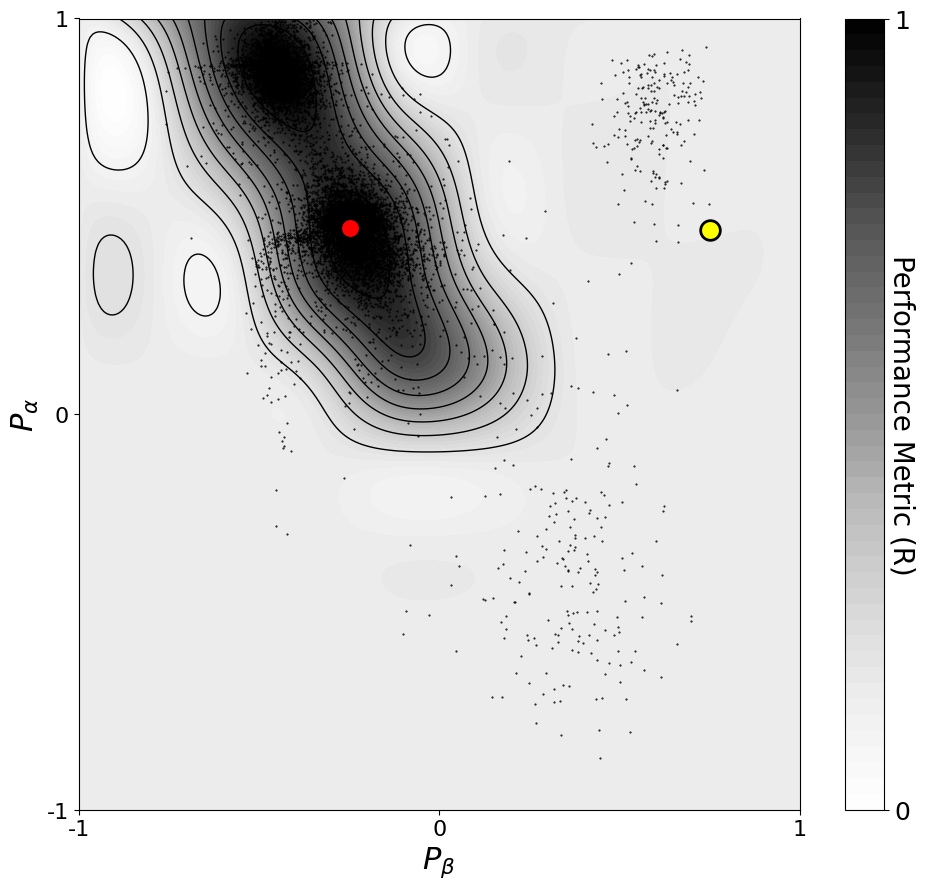

In [ ]:
def plot_spec_traj(syll, day_i, day_f, every_nth_point):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = color_contour_bckg # Match the colormap style from plot_landscape
    levels_ = 50

    def plot_artificial():
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=levels_, cmap=cmap)
        if if_contour:
            axs.contour(X, Y, Z, levels=15, colors='k', linewidths=1, alpha=0.9)
        cbar = fig.colorbar(contour, ax=axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation=270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0, 1])
        axs.set_xticks([-limit, 0, limit], [-1, 0, 1])
        axs.set_yticks([-limit, 0, limit], [-1, 0, 1])

    def plot_syrinx():
        if obj.N_SYLL > 4:
            raise ValueError('Only 4 syllables are available in the syrinx landscape')
        obj.syrinx_contours = []
        obj.syrinx_targets = []
        for j in range(obj.N_SYLL):
            base = np.load(f"contours/Syll{j+1}.npy")
            Z, target = make_contour(base)
            obj.syrinx_contours.append(Z)
            obj.syrinx_targets.append(target)
        obj.centers = np.array(obj.syrinx_targets)
        obj.syrinx_contours = np.array(obj.syrinx_contours)
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        if if_contour:
            axs.contour(Z.T, levels=10, extent=[-1, 1, -1, 1], colors='k', linewidths=1, alpha=1)
        cs = axs.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1], levels=levels_)
        cbar = fig.colorbar(cs, ax=axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation=270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0, 1])
        axs.set_xticks([-1, 0, 1], [-1, 0, 1])
        axs.set_yticks([-1, 0, 1], [-1, 0, 1])
        # axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    # Plot background landscape
    if obj.LANDSCAPE == 0:
        plot_artificial()
    else:
        plot_syrinx()

    # Plot agent trajectory
    x_traj, y_traj = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))
    axs.plot(
        x_traj[day_i * TRIALS: day_f * TRIALS][::every_nth_point],
        y_traj[day_i * TRIALS: day_f * TRIALS][::every_nth_point], color = color_motor, label='Agent Trajectory', alpha=1, linewidth=0.0, marker='.', markersize=1
    )
    axs.scatter(x_traj[0], y_traj[0],
                s=200, c='yellow', edgecolors='black',
                marker='o', linewidths=2, zorder=3, label='Starting Point')

    axs.scatter(x_traj[-1], y_traj[-1],
                s=200, c='red', edgecolors='black',
                marker='o', linewidths=2, zorder=4, label='Ending Point')

    # Labels
    axs.set_ylabel(r'$P_{\alpha}$', fontsize=22)
    axs.set_xlabel(r'$P_{\beta}$', fontsize=22)
    # axs.set_ylabel(r'$P_{\alpha}$ (Pressure)', fontsize=22)
    # axs.set_xlabel(r'$P_{\beta}$ (Tension)', fontsize=22)
    axs.tick_params(labelsize=16)
    # axs.legend()
    plt.tight_layout()
    plt.show()

for i in range(N_SYLL):
    plot_spec_traj(i, 0,60, 5)

### C. Detailed trajectory plot for 1 syllable
Put value of `model_version` as model_3. Because the trajectory is better.

Keep `load` to False and `save` to True if this is the first time using the notebook. Else `load` to True.

In [9]:
# Config
# 1 to load model
# 1 to save model
load = 1
save = 0
model_version = model_3  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")


Model 'model_syrinx_1_37' loaded successfully!


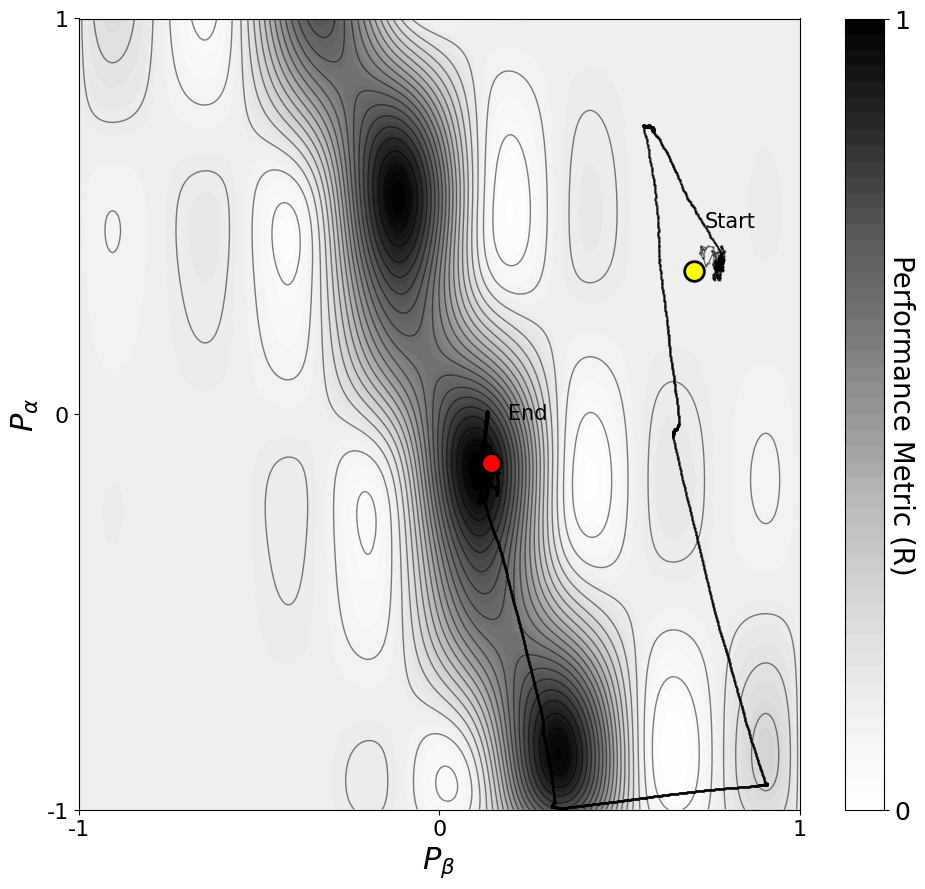

In [ ]:
def plot_spec_avg_traj(syll, day_i, day_f, N_i, N_f, steepness = 5.0):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = color_contour_bckg  # Match the colormap style from plot_landscape
    levels_ = 50

    def plot_artificial():
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=levels_, cmap=cmap)
        if if_contour:
            axs.contour(X, Y, Z, levels=15, colors='k', linewidths=1, alpha=0.9)
        cbar = fig.colorbar(contour, ax=axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation=270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0, 1])
        axs.set_xticks([-limit, 0, limit], [-1, 0, 1])
        axs.set_yticks([-limit, 0, limit], [-1, 0, 1])

    def plot_syrinx():
        if obj.N_SYLL > 4:
            raise ValueError('Only 4 syllables are available in the syrinx landscape')
        obj.syrinx_contours = []
        obj.syrinx_targets = []
        for j in range(obj.N_SYLL):
            base = np.load(f"contours/Syll{j+1}.npy")
            Z, target = make_contour(base)
            obj.syrinx_contours.append(Z)
            obj.syrinx_targets.append(target)
        obj.centers = np.array(obj.syrinx_targets)
        obj.syrinx_contours = np.array(obj.syrinx_contours)
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        if if_contour:
            axs.contour(Z.T, levels=20, extent=[-1, 1, -1, 1], colors='k', linewidths=1, alpha=0.5)
        cs = axs.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1], levels=levels_)
        cbar = fig.colorbar(cs, ax=axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation=270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0, 1])
        axs.set_xticks([-1, 0, 1], [-1, 0, 1])
        axs.set_yticks([-1, 0, 1], [-1, 0, 1])
        # axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    # Plot background landscape
    if obj.LANDSCAPE == 0:
        plot_artificial()
    else:
        plot_syrinx()

    # Plot agent trajectory
    x_traj, y_traj = zip(*obj.actions[:, :, syll, :].reshape(-1, 2))
    # xtraj_smooth = running_mean(np.array(x_traj), N=every_nth_point)
    # ytraj_smooth = running_mean(np.array(y_traj), N=every_nth_point)
    xtraj_smooth = running_mean_dynamic(np.array(x_traj), N_i=N_i, N_f=N_f, steepness=steepness)
    ytraj_smooth = running_mean_dynamic(np.array(y_traj), N_i=N_i, N_f=N_f, steepness=steepness)
    axs.plot(
        xtraj_smooth[day_i * TRIALS: day_f * TRIALS], #[::every_nth_point],
        ytraj_smooth[day_i * TRIALS: day_f * TRIALS],#[::every_nth_point],
        color = color_motor, label='Agent Trajectory', alpha=0.5, linewidth=1, marker='.', markersize=1
    )

    # starting and ending points
    axs.scatter(x_traj[0], y_traj[0],
                s=200, c='yellow', edgecolors='black',
                marker='o', linewidths=2, zorder=3, label='Starting Point')
    axs.text(x_traj[0] + 0.1, y_traj[0] + 0.1, 'Start', fontsize=15, ha='center', va='bottom')
    axs.text(x_traj[-1] + 0.1, y_traj[-1] + 0.1, 'End', fontsize=15, ha='center', va='bottom')
    axs.scatter(x_traj[-1], y_traj[-1],
                s=200, c='red', edgecolors='black',
                marker='o', linewidths=2, zorder=4, label='Ending Point')

    # Labels
    axs.set_ylabel(r'$P_{\alpha}$', fontsize=22)
    axs.set_xlabel(r'$P_{\beta}$', fontsize=22)
    # axs.set_ylabel(r'$P_{\alpha}$ (Pressure)', fontsize=22)
    # axs.set_xlabel(r'$P_{\beta}$ (Tension)', fontsize=22)
    axs.tick_params(labelsize=16)
    # axs.legend()
    plt.tight_layout()
    plt.show()

# for i in range(N_SYLL):
plot_spec_avg_traj(0, 0,60,10, 2000, 10)

/tmp/ipykernel_1252023/2686730320.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))


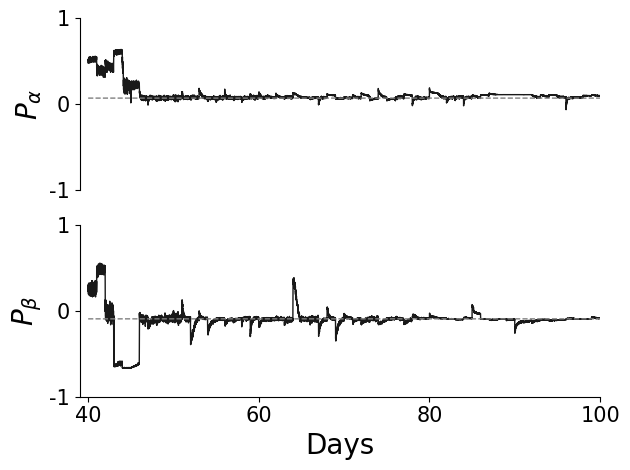

In [13]:
def plot_output(obj, syll):
    figure, (ax1, ax2) = plt.subplots(2,1)
    
    sk = N_SYLL
    LIMIT = 1.5

    # Display x axis in days
    x = np.arange(N_DAILY_MOTIFS)
    x = x/(N_DAILY_MOTIFS * N_SYLL)

    x_bg_traj, y_bg_traj = zip(*obj.actions_bg[:, :, syll, :].reshape(-1, 2))
    ra_actions = obj.actions - obj.actions_bg
    x_ra_traj, y_ra_traj = zip(*ra_actions[:, :, syll, :].reshape(-1, 2))
    x_bg_traj = np.array(x_bg_traj)
    y_bg_traj = np.array(y_bg_traj)
    x_ra_traj = np.array(x_ra_traj)
    y_ra_traj = np.array(y_ra_traj)


    # Plot running average of cortical output (brown), BG output (grey) and total output (black)
    # Data
    # for syll in range(N_SYLL):
        # motor outputs
    ax1.plot(running_mean(obj.actions[:,:,syll,0].reshape(DAYS*N_DAILY_MOTIFS), 10), color=color_motor, lw=1, alpha=.9)
    ax2.plot(running_mean(obj.actions[:,:,syll,1].reshape(DAYS*N_DAILY_MOTIFS), 10), color=color_motor, lw=1, alpha=.9)

    ## RA contribution 
    # ax1.plot(running_mean(x_ra_traj.reshape(DAYS*N_DAILY_MOTIFS), 1), color="brown", lw=1, alpha=.9, label='RA contribution')
    # ax2.plot(running_mean(y_ra_traj.reshape(DAYS*N_DAILY_MOTIFS), 1), color="brown", lw=1, alpha=.9)
    # #     # BG contribution
    # ax1.plot(running_mean(x_bg_traj.reshape(DAYS*N_DAILY_MOTIFS), 10), color="grey", lw=1, alpha=.9, label='BG contribution')
    # ax2.plot(running_mean(y_bg_traj.reshape(DAYS*N_DAILY_MOTIFS), 10), color="grey", lw=1, alpha=.9)
    # for syll in range(N_SYLL - 1):
    #     # target
    #     ax1.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
    #     ax2.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
    # if N_SYLL > 1:
    #     ax1.plot(obj.centers[syll + 1, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1)
    #     ax2.plot(obj.centers[syll + 1, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='red', linestyle='--', linewidth=1, label = 'Target')
    # elif N_SYLL == 1:
    ax1.plot(obj.centers[syll, 1]*np.ones(N_DAILY_MOTIFS*DAYS),  color='grey', linestyle='--', linewidth=1, label = 'Target')
    ax2.plot(obj.centers[syll, 0]*np.ones(N_DAILY_MOTIFS*DAYS),  color='grey', linestyle='--', linewidth=1)

    # Axis beauty
    # ax1.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    # ax2.axvline(x=N_DAYS_INTACT * N_DAILY_MOTIFS, linestyle='--', color='grey', lw=1)
    # ax1.axhline(y=0, linestyle='--', color='black', alpha=0.1)
#         ax1.axhline(y=obj.targetpos[0], linestyle='--', color='black', label='Global optimum')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.get_xaxis().set_ticks([])
    ax1.set_ylim(-LIMIT, LIMIT)
    ax1.tick_params(labelsize=15)
    ax1.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1] )
    ax1.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*(DAYS))
    
    ax2.set_xlabel('Days', fontsize=20)
    ax2.set_yticks([-LIMIT, 0, LIMIT], [-1, 0, 1]   )
    ax2.set_ylim(-LIMIT, LIMIT)
    ax2.tick_params(labelsize=15)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_xlim(-N_DAILY_MOTIFS, N_DAILY_MOTIFS*DAYS)
    # ax2.spines['bottom'].set_bounds(0, obj.n_days+obj.n_lesioned_days)
    
    ax2.set_ylabel(r'$P_{\beta}$', fontsize=20)
    ax1.set_ylabel(r'$P_{\alpha}$', fontsize=20)
    plt.legend(frameon=False, loc='center right', fontsize=12, bbox_to_anchor=(1.03,1))
    plt.xticks(range(0, N_DAILY_MOTIFS*(DAYS+1), 20*N_DAILY_MOTIFS), np.arange(40, DAYS+1+40, 20))
    plt.tight_layout()
    plt.show()

plot_output(obj, 0)

### D. Refer to `Robustness` directory for this figure
### E. Different number of distractors
Modify this `plot_landscape` function to change the appearance. 

In [ ]:
def plot_lansdcape(syll, force_landscape=False, landscape=1):
    fig, axs = plt.subplots(figsize=(10, 9))
    cmap = color_contour_bckg #LinearSegmentedColormap.from_list('white_to_black', ['white', 'rebeccapurple'])
    levels_ = 50
    def plot_artificial():
        limit = obj.limit
        x, y = np.linspace(-limit, limit, 50), np.linspace(-limit, limit, 50)
        X, Y = np.meshgrid(x, y)
        Z = obj.get_reward([X, Y], syll)
        contour = axs.contourf(X, Y, Z, levels=levels_, cmap=cmap)
        if if_contour:
            axs.contour(X, Y, Z, levels=10, colors='k', linewidths=1, alpha=0.9)
        cbar = fig.colorbar(contour, ax=axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation = 270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0,1])

        axs.set_xticks([-limit, 0, limit], [-1, 0, 1])
        axs.set_yticks([-limit, 0, limit], [-1, 0, 1])

    def plot_syrinx():
        if obj.N_SYLL > 4:
            raise ValueError('Only 4 syllables are available in the syrinx landscape')
        obj.syrinx_contours = []
        obj.syrinx_targets = []
        for j in range(obj.N_SYLL):
            base = np.load(f"contours/Syll{j+1}.npy")
            Z, target = make_contour(base)
            obj.syrinx_contours.append(Z)
            obj.syrinx_targets.append(target)
        obj.centers = np.array(obj.syrinx_targets)
        obj.syrinx_contours = np.array(obj.syrinx_contours)
        Z = obj.syrinx_contours[syll]
        target_pos = obj.syrinx_targets[syll]
        if if_contour:
            axs.contour(Z.T, levels=10, extent=[-1, 1, -1, 1], colors='k', linewidths=1, alpha=1)
        cs = axs.contourf(Z.T, cmap=cmap, extent=[-1, 1, -1, 1], levels=levels_)
        cbar = fig.colorbar(cs, ax = axs)
        cbar.set_label('Performance Metric (R)', fontsize=20, rotation = 270)
        cbar.ax.tick_params(labelsize=18)
        cbar.ax.set_yticks([0,1])
        axs.set_xticks([-1, 1], [0, 1])
        axs.set_yticks([-1,1], [0, 0.2])
        # axs.scatter(target_pos[1], target_pos[0], s=100, c='green', marker='x', label='Target')

    if not force_landscape:
        if obj.LANDSCAPE == 0:
            print("No force artificial landscape")
            plot_artificial()
        else:
            plot_syrinx()
    else:
        if landscape == 0:
            plot_artificial()
        else:
            plot_syrinx()

    # axs.set_ylabel(r'$P_{\alpha}$', fontsize=22)
    # axs.set_xlabel(r'$P_{\beta}$', fontsize=22)
    axs.set_ylabel(r'$P_{\alpha}$ (Pressure)', fontsize=22)
    axs.set_xlabel(r'$P_{\beta}$ (Tension)', fontsize=22)
    axs.tick_params(labelsize=16)
    axs.legend()
    plt.tight_layout()
    plt.show()

1
Random seed is 42


100%|██████████| 2/2 [00:00<00:00, 71.93it/s]

No force artificial landscape



/tmp/ipykernel_1252023/3854953797.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


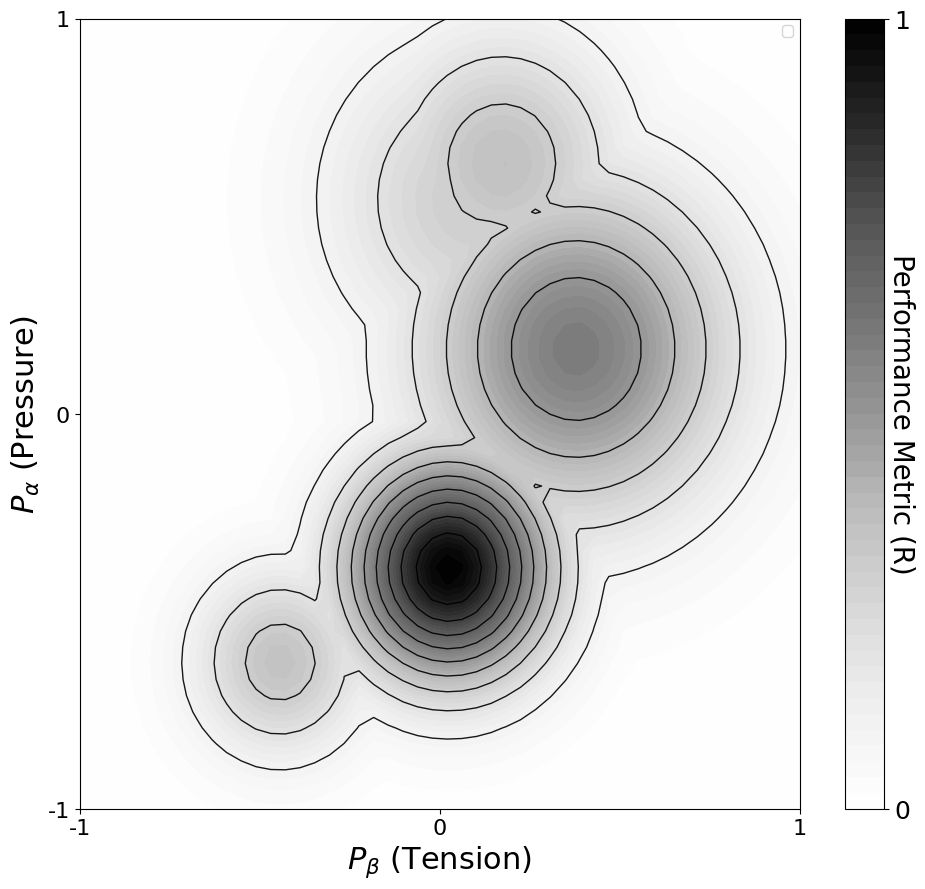

In [15]:
# load parameters from json file
params_path = "params_3_5.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 42
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING) 
print(f'Random seed is {RANDOM_SEED}')

# Donot change
load = 0
save = 0
model_version = "model_syrinx_1_37"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")

plot_lansdcape(0, force_landscape=False, landscape=1)

1
Random seed is 42


100%|██████████| 2/2 [00:00<00:00, 131.65it/s]

No force artificial landscape



/tmp/ipykernel_1252023/3854953797.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


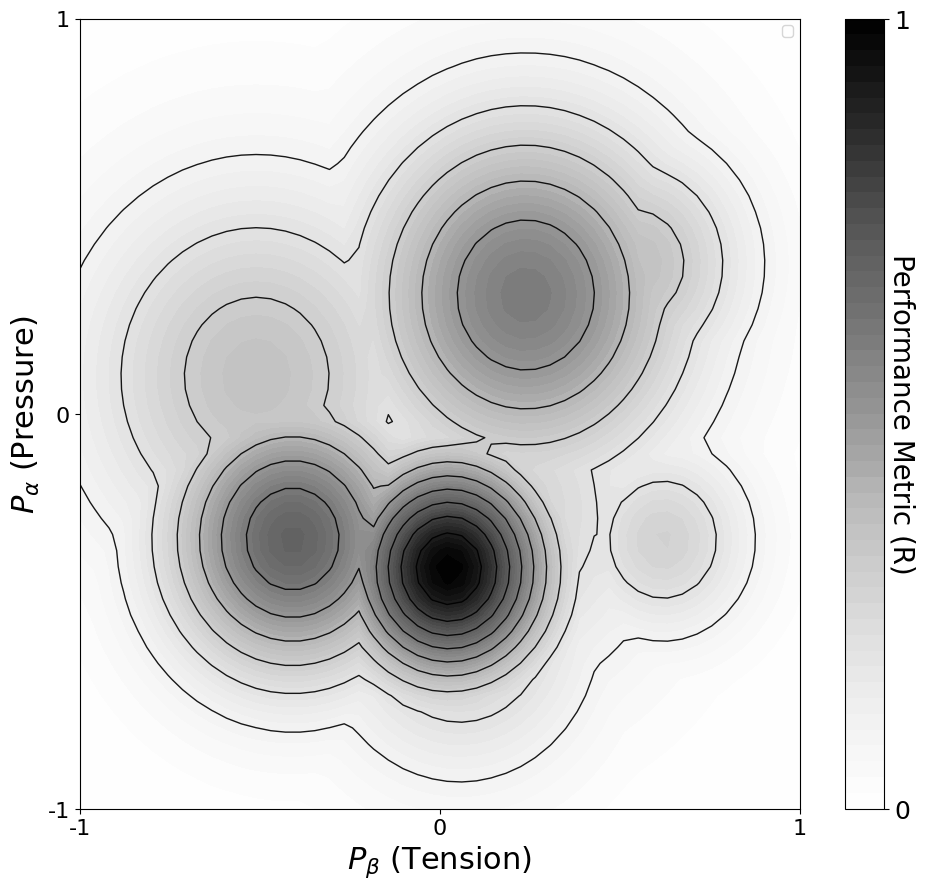

In [16]:
# load parameters from json file
params_path = "params_3_10.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 42
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING) 
print(f'Random seed is {RANDOM_SEED}')

# Donot change
load = 0
save = 0
model_version = "model_syrinx_1_37"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")

plot_lansdcape(0, force_landscape=False, landscape=1)

1
Random seed is 42


100%|██████████| 2/2 [00:00<00:00, 106.57it/s]

No force artificial landscape



/tmp/ipykernel_1252023/3854953797.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


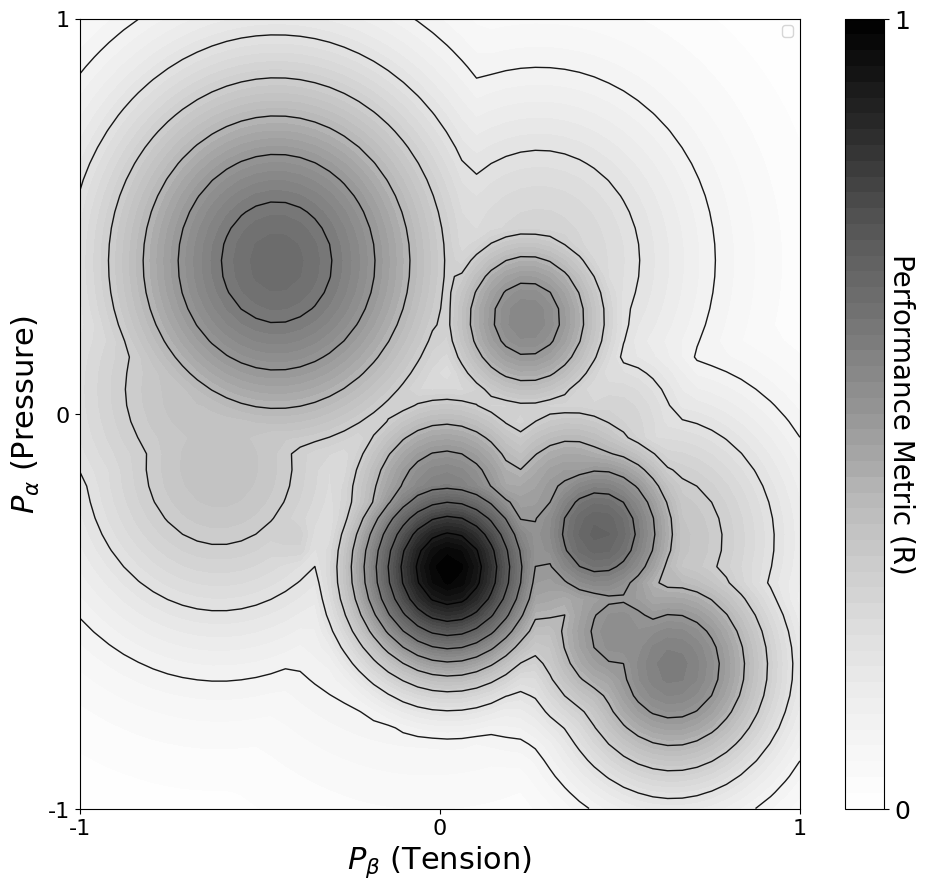

In [17]:
# load parameters from json file
params_path = "params_3_20.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 42
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING) 
print(f'Random seed is {RANDOM_SEED}')

# Config
# 1 to load model
# 1 to save model
load = 0
save = 0
model_version = "model_syrinx_1_37"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")

plot_lansdcape(0, force_landscape=False, landscape=1)

1
Random seed is 42


100%|██████████| 2/2 [00:00<00:00, 108.09it/s]

No force artificial landscape



/tmp/ipykernel_1252023/3854953797.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


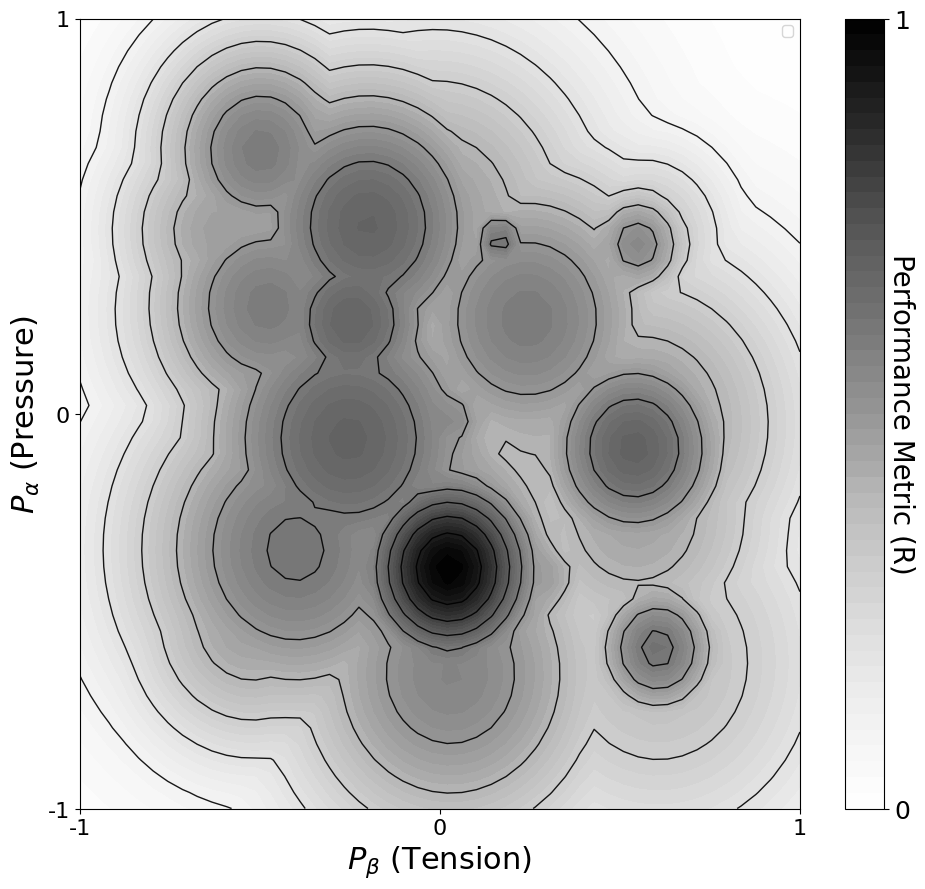

In [18]:
# load parameters from json file
params_path = "params_3_50.json"
# Open the file and read the contents
with open(params_path, "r") as f:
    parameters = json.load(f)

# running conditions
N_DAILY_MOTIFS = parameters['params']['TRIALS'] # trials per day per syllable  # old code TRIALS
TRIALS = N_DAILY_MOTIFS
BG_INTACT_DAYS = parameters['params']['BG_INTACT_DAYS']
DAYS = parameters['params']['DAYS'] # days for learning
N_SYLL = parameters['params']['N_SYLL'] # number of syllables   
if N_SYLL > 5 or N_SYLL < 1:
    ValueError('Invalid number of syllables')
RANDOM_SEED = 42
ANNEALING = parameters['params']['ANNEALING'] # annealing 
print(ANNEALING) 
print(f'Random seed is {RANDOM_SEED}')

# Config
# 1 to load model
# 1 to save model
load = 0
save = 0
model_version = "model_syrinx_1_37"  # e.g., "model","model_1" "model20", "model_4_40", "model_syrinx_4_41"etc.

model_path = f"{model_version}.pkl"

if load:
    if os.path.exists(model_path):
        with open(model_path, 'rb') as f:
            obj = pickle.load(f)
            print(f"Model '{model_version}' loaded successfully!")
    else:
        raise FileNotFoundError(f"Model file '{model_path}' not found.")

else:
    obj = Environment(RANDOM_SEED, parameters, NN)
    obj.run(parameters, ANNEALING)

    if save:
        if os.path.exists(model_path):
            print(f"Model file '{model_path}' already exists. Not overwriting.")
        else:
            try:
                pickle.dumps(obj)  # Test serialization
                with open(model_path, "wb") as f:
                    pickle.dump(obj, f)
                print(f"Model '{model_version}' saved successfully.")
            except pickle.PicklingError:
                print("Object cannot be pickled!")

plot_lansdcape(0, force_landscape=False, landscape=1)

### Spectrograms of maxima's
Change the value of P_alpha and T_beta from 0,0 to something else

In [12]:
P_alpha, T_beta = 0.5, 0.3

In [13]:
np.random.seed(100)
# Parameters
gamma = 12000 

duration = 0.050 #s
dt = 1/44100 #s  #* 0.1 #1.e-4

Amp = 10

# Trachea parameters
r=-0.9
v=350*100
L=1.9
tau_0=2*L/v # Propagation time along trachea
tau_n=int(tau_0/dt)
# ks = np.linspace(0.16,0.52, 10)
# ps = np.linspace(1852,2084, 10)

# Track position and velocity 
nt = int(duration/dt)
X = np.zeros(nt)          # Labial position
Y = np.zeros(nt)          # Velocity

def sigmoid(x):
      return 1 / (1 + np.exp(-x))

def syrinxODE(t, y):
    ''' ODEs used in Amador paper'''
    
    y0, y1 = y
    dydt = [y1,
         -Pressure(t)*(gamma**2) - Tension(t)*(gamma**2)*y0 - (gamma**2)*(y0**3) - gamma*(y0**2)*y1 + (gamma**2)*(y0**2) - gamma*y0*y1
           ]
    return dydt

# RC4
# syllable 1
syllable_array = [1]
P_t_list = []  # <— add before the syllable loop




for syllable in syllable_array:
    if syllable == 1:
        def Tension(t):
            """ Generalised exponential waveform """
            return   .3 - .2*np.exp(-200*t) -.00001 * np.exp(200*t) + T_beta

        
        def Pressure(t):
            """ Constant """
            return 0.04*np.sin((duration/2 + t)*np.pi*10) + 0.05 + P_alpha
    # RC5 - test
    elif syllable == 2:
        # syllable 2
        def Tension(t):
            """ Generalised exponential waveform """
            Tc = 1#2/3
            return   .3 - .2*np.exp(-Tc*3*100*t) -.00001 * np.exp(Tc*3*100*t) + T_beta

        def Pressure(t):
            """ Constant """
            tp = 0.2
            return tp*np.sin((duration/2 + t)*np.pi*10) + 0.05 + P_alpha
    elif syllable == 3:
        # syllable 3
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            scale = 1
            if isinstance(t, float):
                if t <= duration*scale/2: 
                    return 5*np.sin(t*np.pi*40/scale) + 0.6 + T_beta # old amp 0.1
                elif t <= duration*scale: 
                    return 10*np.sin((t-duration*scale/2)*np.pi*15/scale) + 0.6 + T_beta# old amp 0.2
                else: 
                    return 0.0 + 0*t + T_beta
            elif isinstance(t, np.ndarray):
                Tension1 = 5*np.sin(t*np.pi*40/scale) + 0.6 + T_beta# old amp 0.1
                Tension2 = 10*np.sin(t*np.pi*15/scale) + 0.6 + T_beta# old amp 0.2
                Tension3 = 0.0 + 0*t + T_beta
                return np.concatenate((Tension1[:int(np.ceil(t.size*scale/2))], Tension2[:int(t.size*scale-t.size*scale/2)], Tension3[:int(t.size-t.size*scale)]))        
        
        def Pressure(t):
            """ Pressure = 0.02 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 2  + P_alpha # old amp 0.16
    elif syllable == 4:
        # syllable 4
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            scale = 0.4
            if isinstance(t, float):
                if t <= duration*scale: 
                    return 0.8*np.sin(t*np.pi*20/scale) + 0.6 + T_beta # old amp 0.1
                else: 
                    return t*0 + 0.6 + T_beta # old amp 0.2
            elif isinstance(t, np.ndarray):
                Tension1 = 0.8*np.sin(t*np.pi*20/scale) + 0.6 + T_beta # old amp 0.1
                Tension2 = t* 0 + 0.6 + T_beta # old amp 0.2
                return np.concatenate((Tension1[:int(np.ceil(t.size*scale))], Tension2[:int(t.size-t.size*scale)]))
            
        def Pressure(t):
            """ Pressure = 0.02 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.01 + P_alpha
            
    elif syllable == 5:
        # syllable 5
        def Tension(t):
            """ Tension = 0.2 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.2
            
        def Pressure(t):
            """ Pressure = 0.1 * np.ones((nt)) """
            return np.ones((np.asarray(t).shape)) * 0.1
    elif syllable == 6:
        # syllable 6
        def Tension(t):
            """
                Tension1 = 0.1*np.sin(sin_t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(sin_t*np.pi*15) + 0.6
                Tension = np.concatenate((Tension1[:int(np.ceil(nt/2))], Tension2[:int(nt-nt/2)]))
            """
            if isinstance(t, float):
                if t <= duration/2: return 0.1*np.sin(t*np.pi*40) + 0.6
                else: return 0.2*np.sin((t-duration/2)*np.pi*15) + 0.6
            elif isinstance(t, np.ndarray):
                Tension1 = 0.1*np.sin(t*np.pi*40) + 0.6
                Tension2 = 0.2*np.sin(t*np.pi*15) + 0.6
                return np.concatenate((Tension1[:int(np.ceil(t.size/2))], Tension2[:int(t.size-t.size/2)]))
            
        def Pressure(t):
            """ Pressure = 0.01*np.sin(sin_t*np.pi*2*100) + 0.02 """
            return 0.01*np.sin(t*np.pi*2*100) + 0.02
        

    solution = solve_ivp(syrinxODE, [0, duration], [1, 1], method = "RK45", t_eval = np.linspace(0,duration,nt), rtol = 1e-8, atol = 1e-8)
    # Extract labial position (X) and velocity (Y)
    X = solution['y'][0]
    Y = solution['y'][1]
    # Transform into song
    time_x = np.linspace(0, duration, nt)
    song = Amp * Pressure(time_x) * Y
    ## Trachea from Darshan, et. al. https://doi.org/10.1038/ncomms15415

    # Input to trachea = output of syrinx
    y0 = song.T

    # To generate pressure output from trachea
    P_i=np.zeros((len(y0)))

    # See Fig 1 in Amador paper. Round-about way to implement that.
    Buffer = queue.Queue()
    for i in np.arange(tau_n):
        Buffer.put(np.random.random())

    for i in np.arange(len(y0)):
        P_i[i] = y0[i] - r*Buffer.get();      
        # update_buffer
        Buffer.put(P_i[i])

    # P_tr from P_in (ref Amador paper)
    BufferB=np.zeros((tau_n))
    P_tmp= np.concatenate((BufferB, P_i))
    P_t=(1-r)*P_tmp[:-tau_n]
    # ... inside your syllable loop, after computing P_t ...
    P_t_list.append(P_t.copy())
    time_x = np.linspace(0, duration, nt)

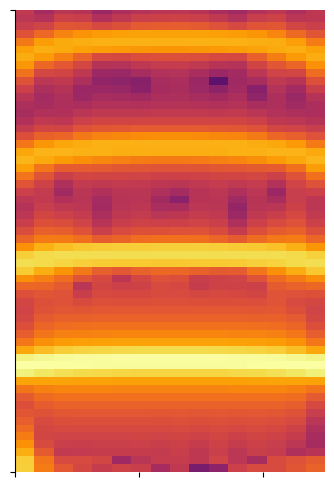

In [15]:
for i in range(len(syllable_array)):
    P_t = P_t_list[i]
    figure, ax = plt.subplots(1)

    (spectrumP, freqsP, t, im) = plt.specgram(P_t, Fs=1/dt, NFFT=256, noverlap=128, xextent=[0,.05], cmap='inferno')
    im


    # ax.set_ylabel('Frequency (kHz)', fontsize=30)
    # ax.set_xlabel('Time (s)', fontsize=30)
    # ax.set_title(f'Syllable:{syllable}', fontsize=30)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_ylim(0,10000)
    ax.set_xlim(0,.05)
    ax.set_xticklabels([])
    ax.set_yticks([0, 10000])
    ax.set_yticklabels([0, 10])
    ax.set_yticklabels([])
    ax.tick_params(labelsize=15)

    figure.set_size_inches(4, 6, forward=True)


    plt.plot()
    plt.show()